<h1><center>Back-end / Classification</center></h1>

# Data preparation

For improvement:
- 10-fold cross validation

In [1]:
import numpy as np

In [2]:
# Paths
FEATURE_PATH = 'front-end/features.npy'
LABEL_PATH = 'front-end/labels.npy'

In [3]:
# Load features and labels
features, labels = np.load(FEATURE_PATH), np.load(LABEL_PATH)

In [4]:
##################################################
#           Auxiliary functions                  #
##################################################

def split_data(data, labels, pc=0.7):
    """
    Split data into three portion: training, validation, test
    
    Parameters:
        data: 2D numpy array
        labels: 1D numpy array
        pc: percentage of training data, spliting done as pc% training, (1-pc)/2% validation and (1-pc)/2% test
    """
    # Preconditions
    if len(data) != len(labels):
        raise ValueError("data and labels lengths has to be equal")
    if not isinstance(pc, float) or pc >= 1 or pc <= 0:
        raise ValueError("invalid percentage for training data")
    
    # Calculate cumulative percentage, to be used for np.split function
    #    np.cumsum([0.7, 0.15]) returns [0.7, 0.85]
    cumulative_pc = np.cumsum([pc, (1 - pc) / 2], dtype=float)
    
    # Permutate indices and split indices array into three sub-arrays
    #    len(data) * cumulative_pc returns [350.7, 425.85]
    #    np.split(indices, [350.7, 425.85]) returns [indices[:350], indices[350:425], indices[425:]]
    indices = np.split(np.random.permutation(len(data)), len(data) * cumulative_pc)
    
    # Return training, validation and test data as a tuple
    return (# training data & labels
            data[indices[0]], labels[indices[0]],
            # validation data & labels
            data[indices[1]], labels[indices[1]],
            # test data & labels
            data[indices[2]], labels[indices[2]]) 

In [5]:
# Split data
data = split_data(features, labels)
train_data, train_label = data[0], data[1]
val_data, val_label = data[2], data[3],
test_data, test_label = data[4], data[5]

//anaconda/envs/tensorflow/lib/python2.7/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


In [6]:
# Print statistics about data
print "Training data/label size: ", len(train_data), \
        "\nValidation data/label size: ", len(val_data), \
        "\nTest data/label size: ", len(test_data)

Training data/label size:  350 
Validation data/label size:  75 
Test data/label size:  76


# Setting up the model

In [7]:
import tensorflow as tf
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_fscore_support)
import matplotlib.pyplot as plt

%matplotlib inline

# Matplotlib styling
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'

In [36]:
# Parameters
n_epochs = 500
n_dim = train_data.shape[1]
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [37]:
# ===== Tensorflow Network ======
# input and output
X = tf.placeholder(tf.float32,[None,n_dim])
y = tf.placeholder(tf.float32,[None,n_classes])

# Feed forward / dense layer
W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

# Feed forward / dense layer
W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

# Output layer
W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [38]:
# 
cost_function = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [39]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_data,y:train_label})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_data})
    y_true = sess.run(tf.argmax(test_label,1))

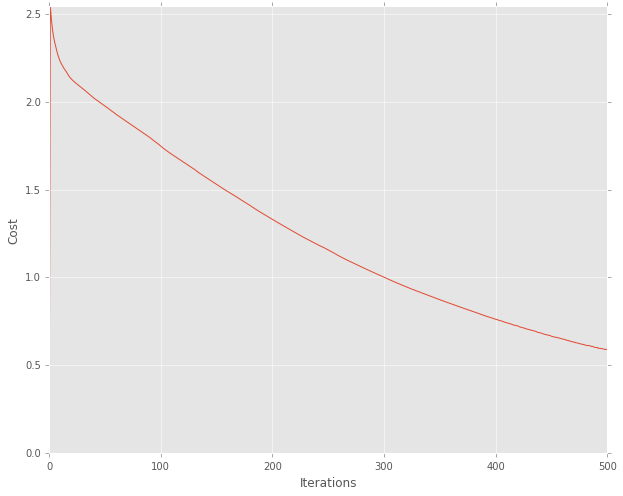

Precision:  0.947
Recall:  0.947
F-Score: 0.947


In [40]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,n_epochs,0,np.max(cost_history)])
plt.show()

accuracy_score, confusion_matrix, 

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "Precision: ", round(p,3)
print "Recall: ", round(r,3)
print "F-Score:", round(f,3)